In [1]:
import numpy as np
import tensorflow.contrib.layers as lays

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# read MNIST dataset
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# 55,000 train samples
# 10,000 test samples
# 28×28 grayscale image

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
batchSize = 64  # Number of samples in each batch
lr = [0.1, 0.01, 0.001]  # Learning rate

In [4]:
# calculate the number of batches per epoch
batch_per_ep = mnist.train.num_examples // batchSize

In [5]:
def autoencoder(inputs):
    # def encoder(inputs):
    net = lays.conv2d(inputs, 8, [3, 3], stride=1, padding='SAME')
    # 28 x 28 x 1   ->  28 x 28 x 8

    net = lays.conv2d(net, 4, [3, 3], stride=1, padding='SAME')
    # 28 x 28 x 8   ->  28 x 28 x 4
    net = tf.layers.max_pooling2d(net, [2,2], 2)
    # 28 x 28 x 4   ->  14 x 14 x 4
    net = lays.conv2d(net, 2, [3, 3], stride=1, padding='SAME')
    # 14 x 14 x 4   ->  14 x 14 x 2
    net = tf.layers.max_pooling2d(net, [2,2], 2)
    # 14 x 14 x 4   ->  7 x 7 x 2

    # def decoder(net):
    net = lays.conv2d_transpose(net, 4, [2, 2], stride=2, padding='SAME')
    # 7 x 7 x 2   ->  14 x 14 x 4
    net = lays.conv2d(net, 4, [3, 3], stride=1, padding='SAME')
    # 14 x 14 x 4   ->  14 x 14 x 4
    net = lays.conv2d_transpose(net, 8, [2, 2], stride=2, padding='SAME')
    # 14 x 14 x 4   ->  28 x 28 x 8
    net = lays.conv2d(net, 8, [3, 3], stride=1, padding='SAME')
    # 28 x 28 x 8   ->  28 x 28 x 8

    net = lays.conv2d(net, 1, [1, 1], stride=1, padding='SAME')
    # 28 x 28 x 8   ->  28 x 28 x 1
    return net

# Calculate loss and cost, define optimizer

In [6]:
input_image_placeholder = tf.placeholder(tf.float32, (None, 28, 28, 1))  # input to the network (MNIST images)
network_output = autoencoder(input_image_placeholder)  # create the Autoencoder network

loss = tf.reduce_mean(tf.square(network_output - input_image_placeholder))

learning_rate_placeholder = tf.placeholder(tf.float32)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate=learning_rate_placeholder).minimize(cost)

# Initialize the network

In [7]:
init = tf.global_variables_initializer()

# Save the costs for later ploting

In [8]:
costCurve = [[] for x in range(len(lr))]

# Training the Autoencoder and creating reconstructed images

In [10]:
sess = tf.Session()
for idx in range(len(lr)):  # epochs loop
    sess.run(init)
    for batch_n in range(batch_per_ep):  # batches loop
        batchTrain_X, batchLabel = mnist.train.next_batch(batchSize)
        imgsTrain= batchTrain_X.reshape((-1, 28, 28, 1))
        _, c = sess.run([opt, loss], feed_dict={learning_rate_placeholder : lr[idx], input_image_placeholder: imgsTrain})
        costCurve[idx].append(c)

# Test the trained network and plot (without noise)

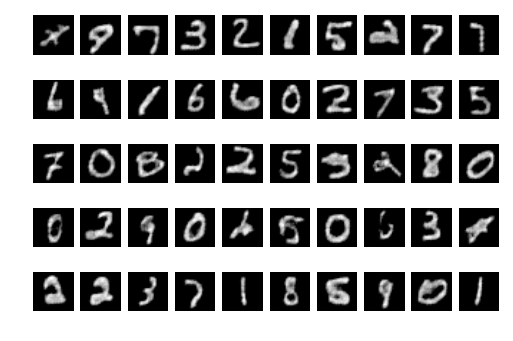

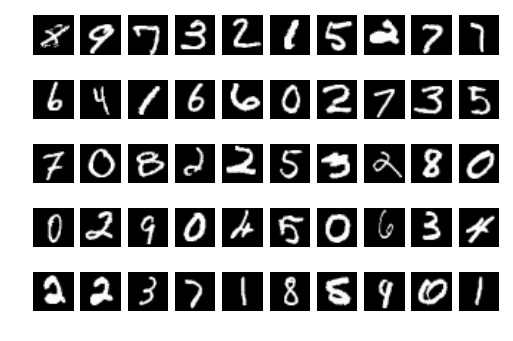

In [12]:
batchTest_X, batchLabel = mnist.test.next_batch(50)  
imgsTest = batchTest_X.reshape((-1, 28, 28, 1))

reconstImg = sess.run([network_output], feed_dict={input_image_placeholder: imgsTest})[0]

# plot the reconstructed images and their ground truths (inputs)
plt.figure(1)
plt.title('Reconstructed Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(reconstImg[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.figure(2)
plt.title('Input Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(imgsTest[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()

# Test the trained network and plot (with little noise)

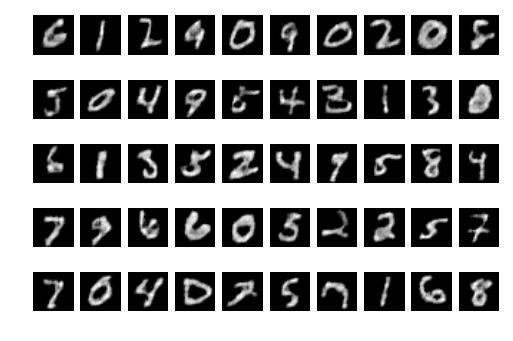

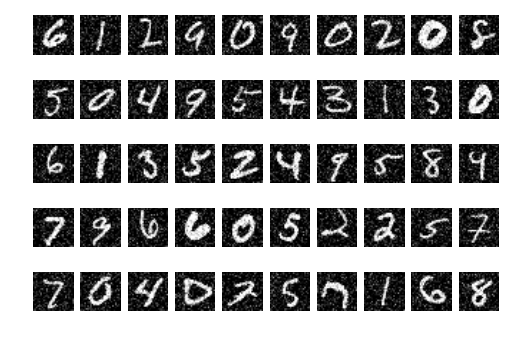

In [13]:
batchTest_X, batchLabel = mnist.test.next_batch(50)  
imgsTest = batchTest_X.reshape((-1, 28, 28, 1))

# smalle noise
noise_factor = 0.2
imgsTest = imgsTest + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgsTest.shape) 
imgsTest = np.clip(imgsTest, 0., 1.)

reconstImg = sess.run([network_output], feed_dict={input_image_placeholder: imgsTest})[0]

# plot the reconstructed images and their ground truths (inputs)
plt.figure(1)
plt.title('Reconstructed Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(reconstImg[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.figure(2)
plt.title('Input Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(imgsTest[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()

# Test the trained network and plot (with lots of noise)

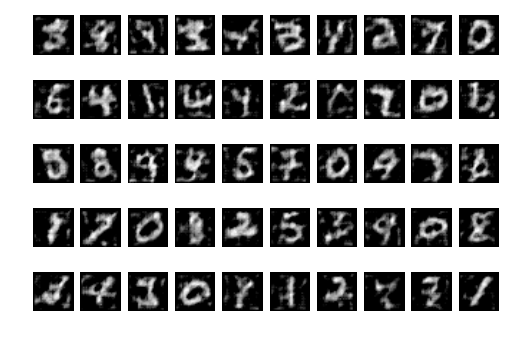

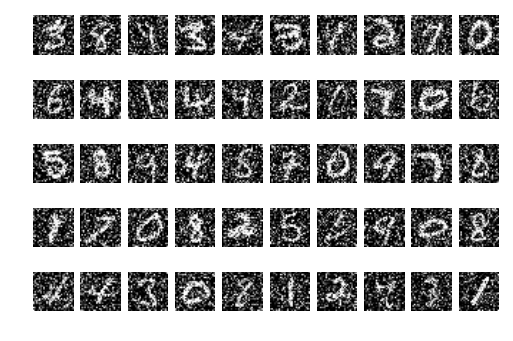

In [14]:
batchTest_X, batchLabel = mnist.test.next_batch(50)  
imgsTest = batchTest_X.reshape((-1, 28, 28, 1))

# lot of noise
noise_factor = 0.5
imgsTest = imgsTest + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgsTest.shape) 
imgsTest = np.clip(imgsTest, 0., 1.)

reconstImg = sess.run([network_output], feed_dict={input_image_placeholder: imgsTest})[0]

# plot the reconstructed images and their ground truths (inputs)
plt.figure(1)
plt.title('Reconstructed Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(reconstImg[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.figure(2)
plt.title('Input Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(imgsTest[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()

# Cost plot of all learning rates

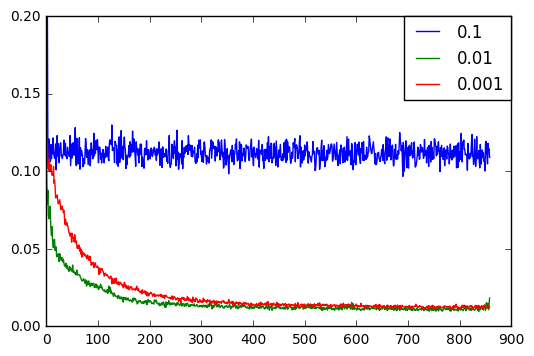

In [15]:
plt.figure(3)
axes = plt.gca()
axes.set_ylim([0,0.2])
for idx in range(len(lr)):
    plt.plot(costCurve[idx], label=str(lr[idx]))
plt.legend(borderaxespad=0.)
plt.show()